In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [3]:
from joblib import Memory

In [4]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [5]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [6]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [7]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

# Load data

In [8]:
TEMP = 91
home_dir = "/project/dinner/scguo/kaiB"
base_dir = f"{home_dir}/dga/new_{TEMP}"
data_dir = f"{base_dir}/data"

In [9]:
traj_files = []
for i in range(1, 12289):
    j = i // 1000
    for iso in ("cis", "trans"):
        head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
        listed = glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.h5")
        if len(listed) != 0:
            traj_files.extend(listed)

In [10]:
len(traj_files)

22989

In [11]:
def load_cv(basename):
    arrays = []
    for file in sorted(glob.glob(f"{basename}_??.npy")):
        arrays.append(np.load(file))
    return np.concatenate(arrays)

In [12]:
fs_qtots = load_cv(f"{data_dir}/fs_qtots")
f_rmsds = load_cv(f"{data_dir}/f_rmsds")
r_rmsds = load_cv(f"{data_dir}/r_rmsds")
p_rmsds = load_cv(f"{data_dir}/p_rmsds")
q_gs_all = load_cv(f"{data_dir}/q_gs_all")
q_gs = load_cv(f"{data_dir}/q_gs")
q_fs_all = load_cv(f"{data_dir}/q_fs_all")
q_fs = load_cv(f"{data_dir}/q_fs")
q_core = load_cv(f"{data_dir}/q_core")
omegas = load_cv(f"{data_dir}/omegas")

In [13]:
fs_qtots.shape, q_gs.shape, omegas.shape

((22989, 8, 1001), (22989, 1001), (22989, 1001, 7))

In [14]:
weights = np.load(f"{data_dir}/mbar_weights.npy")

In [15]:
weights.shape

(384, 32000)

In [16]:
def get_traj_ids(base_dir):
    ids = []
    k = 0
    for i in range(1, 12289):
        j = i // 1000
        for iso in ("cis", "trans"):
            head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
            if len(glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.up")) > 0:
                ids.append(k)
            k += 1
    return np.array(ids)


def get_weights(weights, N, k, ids):
    sampled_w = np.concatenate(weights[:, -N::k])
    # set weight for cis/trans to be the same
    sampled_w = np.repeat(sampled_w, 2)
    return sampled_w[ids]

In [17]:
ids = get_traj_ids(base_dir)
print(len(ids))

22989


In [18]:
N = 32000
k = 1000
sample_w = get_weights(weights, N, k, ids)
print(sample_w.shape)

(22989,)


In [19]:
c_green = fs_qtots[:, 5] - fs_qtots[:, 4]
c_blue = fs_qtots[:, 7] - fs_qtots[:, 6]
c_orange = fs_qtots[:, 3] - fs_qtots[:, 2]
c_0 = fs_qtots[:, 1] - fs_qtots[:, 0]

In [20]:
n_cis = np.sum((np.abs(omegas[..., 3:]) <= (np.pi / 2.0)).astype(int), axis=-1)
p63_cis = (np.abs(omegas[..., 3]) <= (np.pi / 2.0)).astype(int)
p70_cis = (np.abs(omegas[..., 4]) <= (np.pi / 2.0)).astype(int)
p71_cis = (np.abs(omegas[..., 5]) <= (np.pi / 2.0)).astype(int)
p72_cis = (np.abs(omegas[..., 6]) <= (np.pi / 2.0)).astype(int)

# CVs

In [21]:
names = ["blue", "green", "orange", "c0", "r_rmsd", "q_gs_all", "q_fs_all", "q_core", "n_cis"]
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow\beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    c0=r"$\alpha2_{\mathrm{fs}}\longleftrightarrow\beta3_{\mathrm{gs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_core=r"$Q_{\mathrm{N-term}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
)
cvs = dict(
    blue=c_blue,
    green=c_green,
    orange=c_orange,
    c0=c_0,
    r_rmsd=r_rmsds,
    q_gs_all=q_gs_all,
    q_fs_all=q_fs_all,
    q_core=q_core,
    n_cis=n_cis,
)
lims = dict(
    blue=(-1, 1.3),
    green=(-1.3, 1),
    orange=(-1.3, 1),
    c0=(-1, 1.3),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
)

## state definitions

In [22]:
in_fs = (c_green < -0.65) & (c_blue < -0.8) & (c_orange < -0.85) & (q_fs_all > 0.61) & (q_fs > 0.75) & (f_rmsds < 0.35)
in_gs = (c_green > 0.55) & (c_blue > 0.90) & (c_orange > 0.75) & (q_gs_all > 0.62) & (q_gs > 0.7) & (p_rmsds < 0.45)

In [23]:
total_N = np.prod(q_gs_all.shape)
print(np.count_nonzero(in_fs), np.count_nonzero(in_gs))
print(np.count_nonzero(in_fs) / total_N * 100, np.count_nonzero(in_gs) / total_N * 100)

783922 870872
3.40658080446675 3.78442732612118


In [24]:
(np.nonzero(in_fs)[0][:20], np.nonzero(in_fs)[1][:20])

(array([3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072,
        3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072]),
 array([10, 12, 14, 22, 25, 30, 31, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45,
        46, 47, 49]))

# dimensionality reduction and clustering

In [25]:
#fmt:off
union_contact_ids = {128, 129, 3, 262, 263, 264, 142, 19, 24, 282, 26, 27, 285, 
                     286, 284, 33, 34, 35, 297, 42, 43, 44, 299, 48, 177, 52, 53, 
                     308, 309, 58, 63, 194, 195, 324, 196, 70, 83, 212, 213, 100, 231, 114, 115, 242}
#fmt:on

In [26]:
# load raw distances
raw_contact_ds = load_cv(f"{data_dir}/contact_dists")[..., np.array(list(union_contact_ids))]

In [27]:
print(raw_contact_ds.shape)

(22989, 1001, 44)


In [33]:
# IVAC
@memory.cache
def compute_ivac(trajs, minlag, maxlag, nevecs, **kwargs):
    ivac_obj = ivac.LinearIVAC(minlag, maxlag, nevecs=nevecs, **kwargs)
    ivac_obj.fit(trajs)
    ivac_trajs = ivac_obj.transform(trajs)
    return ivac_obj, ivac_trajs

In [34]:
minlag, maxlag = 1, 200
nevecs = 5
ivac_obj, ivac_trajs = compute_ivac(raw_contact_ds, minlag, maxlag, nevecs, adjust=True)

________________________________________________________________________________
[Memory] Calling __main__--scratch-local-jobs-15966841-ipykernel-2339382532.compute_ivac...
compute_ivac(array([[[1.473908, ..., 0.519167],
        ...,
        [1.787436, ..., 0.494827]],

       ...,

       [[6.150638, ..., 4.693075],
        ...,
        [1.796111, ..., 2.36332 ]]], dtype=float32), 
1, 200, 5, adjust=True)
____________________________________________________compute_ivac - 59.8s, 1.0min


/scratch/local/jobs/15966841/ipykernel_1686163/1289938571.py:3: UserWarning: Persisting input arguments took 9.76s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  ivac_obj, ivac_trajs = compute_ivac(raw_contact_ds, minlag, maxlag, nevecs, adjust=True)


## clustering

In [29]:
from joblib import Memory

In [30]:
memory = Memory(data_dir)

In [31]:
@memory.cache
def kmeans_cluster(trajs, k=300):
    flattened_trajs = np.concatenate(trajs)
    kmeans_obj = MiniBatchKMeans(n_clusters=k)
    kmeans_obj.fit(flattened_trajs)
    nneighbors = NearestNeighbors(n_neighbors=1)
    nneighbors.fit(kmeans_obj.cluster_centers_)
    dtrajs = nneighbors.kneighbors(flattened_trajs, 1, return_distance=False)
    return dtrajs

In [38]:
# load clusters
dtrajs1 = np.load(f"{data_dir}/dtrajs_ivac_omegas.npy")

### try more clusters

In [35]:
omega_features = np.cos(omegas[..., 3:])
feature_trajs = np.concatenate([np.asarray(ivac_trajs)[..., 1:], omega_features], axis=-1)
print(feature_trajs.shape)

(22989, 1001, 8)


In [37]:
dtrajs_k = []
k_scan = [300, 400, 500]
for k in k_scan:
    dtraj = kmeans_cluster(feature_trajs, k)
    dtrajs_k.append(dtraj)

In [40]:
# check proline states in clusters
def compute_cluster_average(dtrajs, cv, k=200):
    cv_arr = np.concatenate(cv)
    n_cvs = cv_arr.shape[-1]
    avgs = np.zeros((k, n_cvs))
    stds = np.zeros((k, n_cvs))
    for i in range(k):
        cv_cluster = cv_arr[dtrajs == i]
        avgs[i] = np.mean(cv_cluster, axis=0)
        stds[i] = np.std(cv_cluster, axis=0)
    return avgs, stds

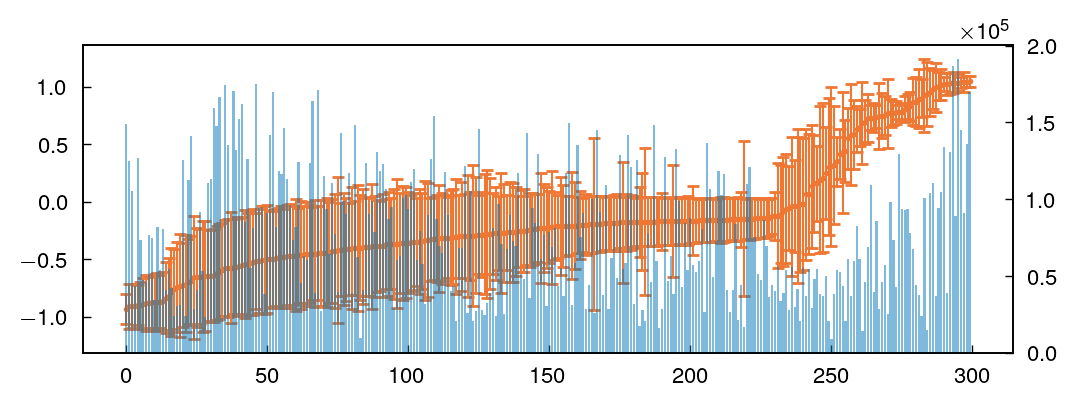

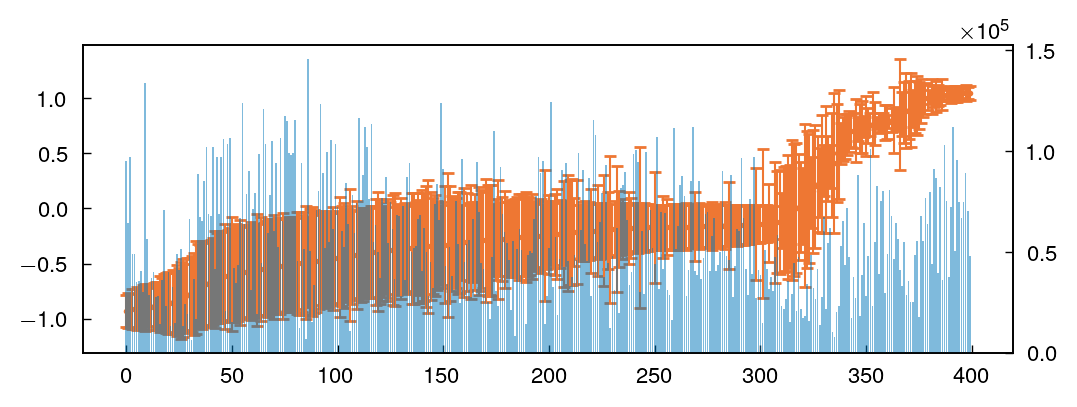

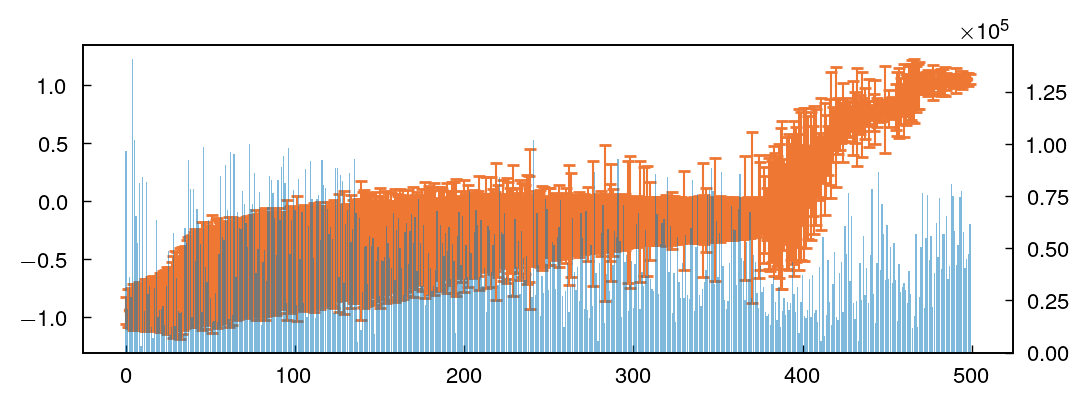

In [43]:
for k, dtraj in zip(k_scan, dtrajs_k):
    n_per_cluster = np.zeros(k)
    for i in range(k):
        n_per_cluster[i] = np.count_nonzero(dtraj == i)
    cluster_blue = compute_cluster_average(dtraj, c_blue[..., None], k=k)
    sort_ids = np.argsort(cluster_blue[0].squeeze())
    fig = plt.figure(figsize=(6, 2), dpi=200)
    plt.errorbar(
        np.arange(k),
        cluster_blue[0].squeeze()[sort_ids],
        yerr=cluster_blue[1].squeeze()[sort_ids],
        fmt=".",
        capsize=2,
    )
    plt.twinx()
    plt.bar(np.arange(k), n_per_cluster[sort_ids], color='C1', alpha=0.5, zorder=0)

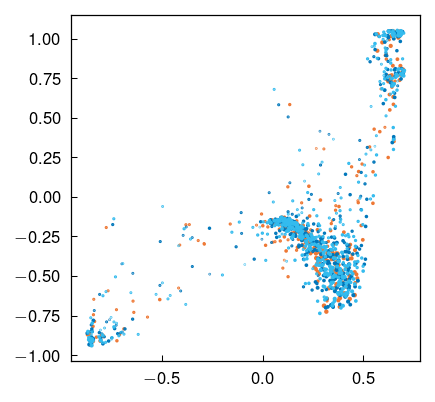

In [65]:
# plot cluster centers
for k, dtraj in zip(k_scan, dtrajs_k):
    n_per_cluster = np.zeros(k)
    for i in range(k):
        n_per_cluster[i] = np.count_nonzero(dtraj == i)
    n_per_cluster /= 1e5
    cluster_blue = compute_cluster_average(dtraj, c_blue[..., None], k=k)
    cluster_green = compute_cluster_average(dtraj, c_green[..., None], k=k)
    plt.scatter(cluster_green[0], cluster_blue[0], s=n_per_cluster)

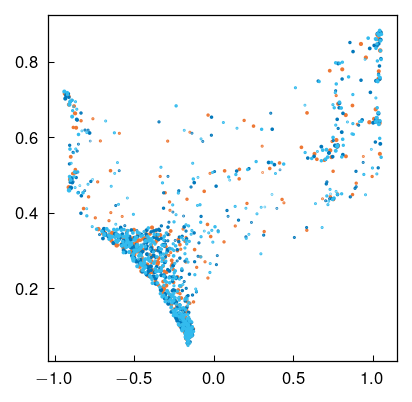

In [66]:
# plot cluster centers
for k, dtraj in zip(k_scan, dtrajs_k):
    n_per_cluster = np.zeros(k)
    for i in range(k):
        n_per_cluster[i] = np.count_nonzero(dtraj == i)
    n_per_cluster /= 1e5
    cluster_blue = compute_cluster_average(dtraj, c_blue[..., None], k=k)
    cluster_qc = compute_cluster_average(dtraj, q_core[..., None], k=k)
    plt.scatter(cluster_blue[0], cluster_qc[0], s=n_per_cluster)

### Try clustering on raw contacts : BAD

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
# standardize contact dists
contact_ds_std = StandardScaler(copy=False).fit_transform(np.concatenate(raw_contact_ds))
omega_features = np.cos(omegas[..., 3:])
feature_trajs = np.concatenate([np.reshape(contact_ds_std, (-1, 1001, 44)), omega_features], axis=-1)
print(feature_trajs.shape)

(22989, 1001, 48)


In [69]:
dtraj_cont = kmeans_cluster(feature_trajs, 200)

________________________________________________________________________________
[Memory] Calling __main__--scratch-local-jobs-15966841-ipykernel-3348954603.kmeans_cluster...
kmeans_cluster(array([[[-0.729192, ..., -0.993827],
        ...,
        [-0.569819, ..., -0.995566]],

       ...,

       [[ 1.648082, ..., -0.793756],
        ...,
        [-0.565409, ..., -0.993653]]], dtype=float32), 
200)


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


_______________________________________________kmeans_cluster - 1066.0s, 17.8min


/scratch/local/jobs/15966841/ipykernel_1686163/1848585779.py:1: UserWarning: Persisting input arguments took 7.42s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  dtraj_cont = kmeans_cluster(feature_trajs, 200)


In [ ]:
# plot cluster centers
k = 200
n_per_cluster = np.zeros(k)
for i in range(k):
    n_per_cluster[i] = np.count_nonzero(dtraj_cont == i)
n_per_cluster /= 1e5
cluster_blue = compute_cluster_average(dtraj_cont, c_blue[..., None], k=k)
cluster_green = compute_cluster_average(dtraj_cont, c_green[..., None], k=k)

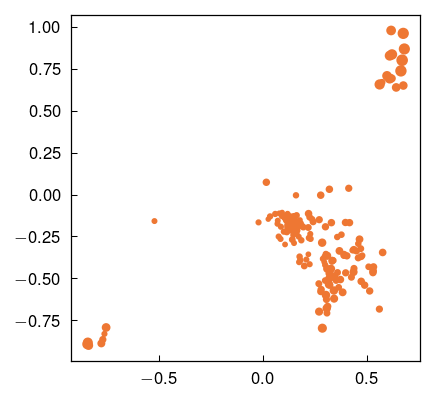

In [72]:
plt.scatter(cluster_green[0], cluster_blue[0], s=n_per_cluster * 5)

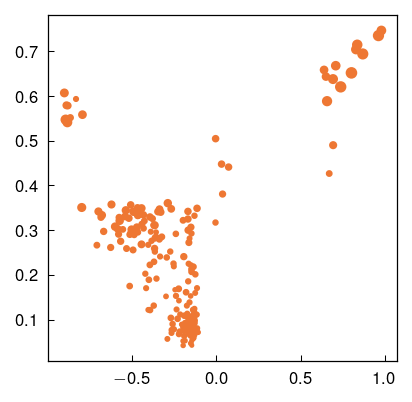

In [74]:
cluster_qc = compute_cluster_average(dtraj_cont, q_core[..., None], k=k)
plt.scatter(cluster_blue[0], cluster_qc[0], s=n_per_cluster * 5)

# DGA calculations

In [45]:
lags = [10, 20, 50, 100]

## basis

In [44]:
def make_sparse_basis(dtrajs):
    """Converts a discretized trajectory (e.g. from k-means clustering)
    into a sparse basis of indicator functions.

    Parameters
    ----------
    dtrajs : ndarray
        discretized trajectories

    Return
    ------
    basis : scipy.sparse.csr_matrix
    """
    nclusters = len(np.unique(dtrajs))
    rows, cols = [], []
    for i in range(nclusters):
        pts = np.argwhere(dtrajs == i)
        # indices of which frames are in the cluster i
        rows.append(pts.squeeze())
        # all assigned as 1 in the basis
        cols.append(np.repeat(i, len(pts)))
    rows = np.hstack(rows)
    cols = np.hstack(cols)
    data = np.ones(len(rows), dtype=float)
    basis = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(dtrajs), nclusters))
    return basis

In [31]:
# split into lists of arrays
basis_d_arr = make_sparse_basis(np.squeeze(dtrajs1))
basis_d_arr[in_fs.ravel()] = 0
basis_d_arr[in_gs.ravel()] = 0

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [32]:
print(np.where(np.sum(basis_d_arr, axis=0) == 0))

(array([], dtype=int64), array([], dtype=int64))


In [33]:
basis_d = []
n_traj, n_frame = c_green.shape[:2]
for i in range(n_traj):
    basis_d.append(basis_d_arr[i * n_frame : (i + 1) * n_frame])

In [34]:
print(len(basis_d), basis_d[0].shape)

22989 (1001, 200)


## Committors

In [46]:
in_d = ~(in_gs | in_fs)
print(in_d.shape)

(22989, 1001)


In [38]:
lag = 5
mem = 0
w = np.array(np.broadcast_to(sample_w[..., None], q_gs.shape))
w[:, -lag:] = 0
qp = extq.dga.forward_committor(basis_d, w, in_d, in_fs.astype(float), lag)
qm = extq.memory.backward_committor(basis_d, w, in_d, in_gs.astype(float), lag, mem)

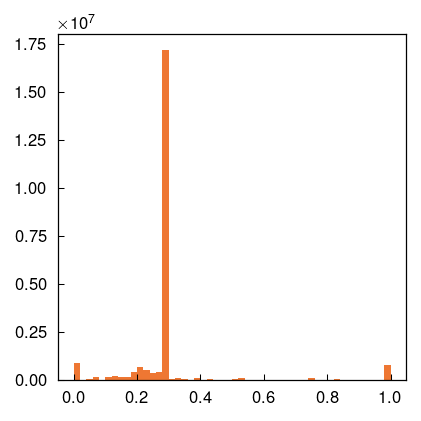

In [39]:
_ = plt.hist(np.concatenate(qp), bins=50)

In [47]:
@memory.cache
def compute_committor(lag, mem):
    qp = extq.memory.forward_committor(basis_d, w, in_d, in_fs.astype(float), lag, mem)
    qm = extq.memory.backward_committor(basis_d, w, in_d, in_gs.astype(float), lag, mem)
    return qp, qm

In [154]:
qp_gs2fs, qm_gs2fs = {}, {}
mems = [0, 1, 4]
for lag in lags:
    w = np.array(np.broadcast_to(sample_w[..., None], q_gs.shape))
    w[:, -lag:] = 0
    for mem in mems:
        print(f"Computing committors with lag {lag} and mem {mem}")
        qp, qm = compute_committor(lag, mem)
        qp_gs2fs[(lag, mem)] = qp
        qm_gs2fs[(lag, mem)] = qm

Computing committors with lag 10 and mem 0
________________________________________________________________________________
[Memory] Calling __main__--scratch-local-jobs-15766754-ipykernel-3645651309.compute_committor...
compute_committor(10, 0)
______________________________________________compute_committor - 413.6s, 6.9min
Computing committors with lag 10 and mem 1
________________________________________________________________________________
[Memory] Calling __main__--scratch-local-jobs-15766754-ipykernel-3645651309.compute_committor...
compute_committor(10, 1)
______________________________________________compute_committor - 449.9s, 7.5min
Computing committors with lag 10 and mem 4
________________________________________________________________________________
[Memory] Calling __main__--scratch-local-jobs-15766754-ipykernel-3645651309.compute_committor...
compute_committor(10, 4)
______________________________________________compute_committor - 566.6s, 9.4min
Computing committor

## different clusters

In [54]:
def compute_committor_k(dtraj, lag, mem):
    w = np.array(np.broadcast_to(sample_w[..., None], q_gs.shape))
    w[:, -lag:] = 0
    basis_d_arr = make_sparse_basis(np.squeeze(dtraj))
    basis_d_arr[in_fs.ravel()] = 0
    basis_d_arr[in_gs.ravel()] = 0
    print(np.where(np.sum(basis_d_arr, axis=0) == 0))
    basis_d = []
    n_traj, n_frame = c_green.shape[:2]
    for i in range(n_traj):
        basis_d.append(basis_d_arr[i * n_frame : (i + 1) * n_frame])

    qp = extq.memory.forward_committor(basis_d, w, in_d, in_fs.astype(float), lag, mem)
     # = extq.memory.backward_committor(basis_d, w, in_d, in_gs.astype(float), lag, mem)
    return qp

In [55]:
qps_k = []
for dtraj in dtrajs_k:
    qps_k.append(compute_committor_k(dtraj, 10, 0))

(array([], dtype=int64), array([], dtype=int64))


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


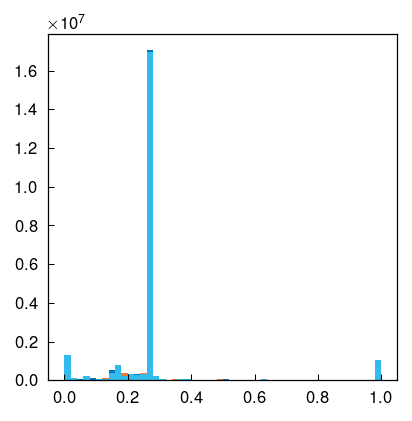

In [56]:
for qp in qps_k:
    plt.hist(np.ravel(qp), bins=50)

In [58]:
skip = 100
inds = random.sample(range(total_N), total_N // skip)

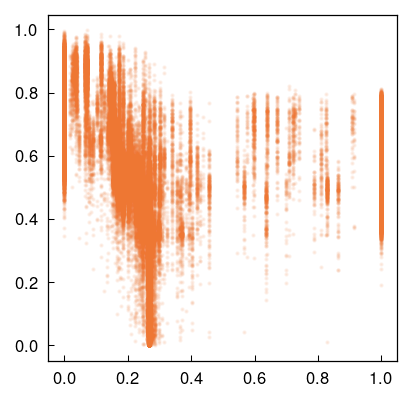

In [59]:
plt.plot(np.ravel(qp)[inds], np.ravel(q_core)[inds], '.', alpha=0.1)

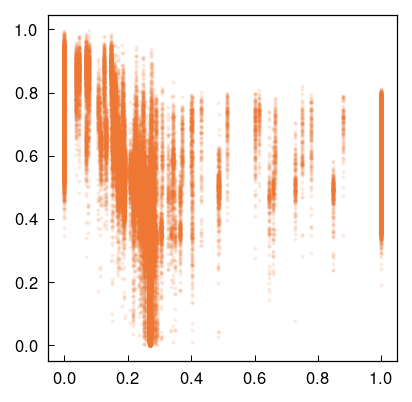

In [60]:
plt.plot(np.ravel(qps_k[0])[inds], np.ravel(q_core)[inds], '.', alpha=0.1)

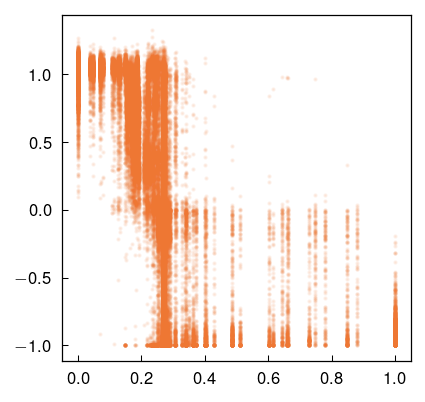

In [62]:
plt.plot(np.ravel(qps_k[0])[inds], np.ravel(c_blue)[inds], '.', alpha=0.1)

In [75]:
qp_cont = compute_committor_k(dtraj_cont, 10, 0)

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(array([], dtype=int64), array([], dtype=int64))


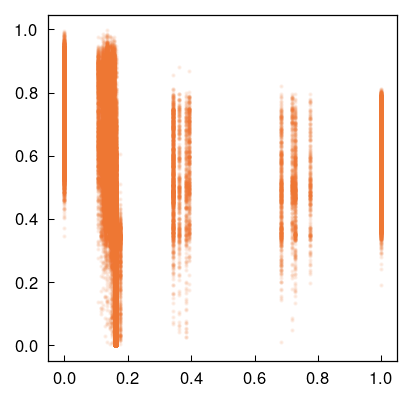

In [76]:
plt.plot(np.ravel(qp_cont)[inds], np.ravel(q_core)[inds], '.', alpha=0.1)